## Import and Path Stuff

In [251]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
test_output_vals = np.load("/content/drive/MyDrive/ML_Forex_Saved_Stuff/test_output_vals.npy")
y_test_new = np.load("/content/drive/MyDrive/ML_Forex_Saved_Stuff/y_test_new.npy")

In [252]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Defining custom performance metric

In [253]:
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

## Loading the dataset

In [254]:
#reading dataset
exchange_data = pd.read_csv('forex_data_10y.csv')
exchange_data.head()

,Date,Price,Open,High,Low,Volume,Chg%
0,25-Aug-20,74.327,74.100,74.335,74.075,0.92K,0.22%
1,24-Aug-20,74.168,74.922,74.922,73.962,4.90K,-1.01%
2,23-Aug-20,74.922,74.922,74.922,74.922,0,0.00%
3,21-Aug-20,74.920,74.980,75.005,74.820,3.16K,-0.12%
4,20-Aug-20,75.012,74.973,75.132,74.935,3.70K,0.22%


## Preprocessing the dates

In [255]:
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)

In [256]:
ind_exchange_data.head()

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2020-08-25,74.327,74.100,74.335,74.075,0.92K,0.22%
2020-08-24,74.168,74.922,74.922,73.962,4.90K,-1.01%
2020-08-23,74.922,74.922,74.922,74.922,0,0.00%
2020-08-21,74.920,74.980,75.005,74.820,3.16K,-0.12%
2020-08-20,75.012,74.973,75.132,74.935,3.70K,0.22%


In [257]:
# sort the dates
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame.head()

,Chg%,High,Low,Open,Price,Volume
Date,,,,,,
2010-08-26,-0.13%,46.910,46.505,46.825,46.845,0
2010-08-27,-0.07%,47.010,46.565,46.755,46.810,0
2010-08-30,0.22%,46.935,46.385,46.725,46.915,0
2010-08-31,0.32%,47.150,46.505,46.875,47.065,0
2010-09-01,-0.83%,47.045,46.575,47.045,46.675,0


In [258]:
df=data_frame
import seaborn as sns

## Exploratory Data Analysis

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



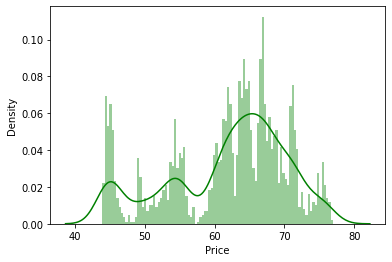

In [259]:
sns.distplot(df.loc[:]['Price'],color='green',bins=100)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



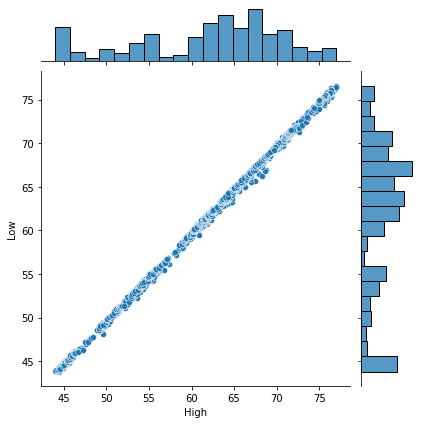

In [260]:
sns.jointplot(df.High,df.Low)

In [261]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df.Price)])
fig.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



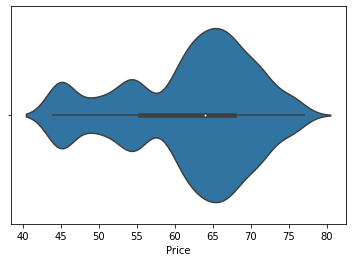

In [262]:
sns.violinplot(df.Price);

In [263]:
df.describe()

,High,Low,Open,Price
count,2610.000000,2610.000000,2610.000000,2610.000000
mean,62.082989,61.735948,61.894726,61.902513
std,8.491155,8.503661,8.502360,8.493784
min,43.975000,43.830000,43.890000,43.925000
25%,55.636250,55.191000,55.396250,55.391250
50%,64.127500,63.832000,63.985000,64.008500
75%,67.991250,67.676500,67.819250,67.807250
max,77.010000,76.583000,76.930000,76.975000


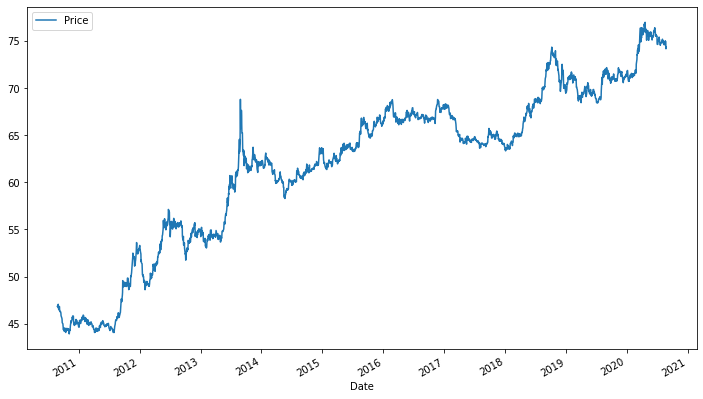

In [264]:
df = data_frame[["Price"]]
df.plot(kind='line',figsize=(12,7))

##Train-Test Split

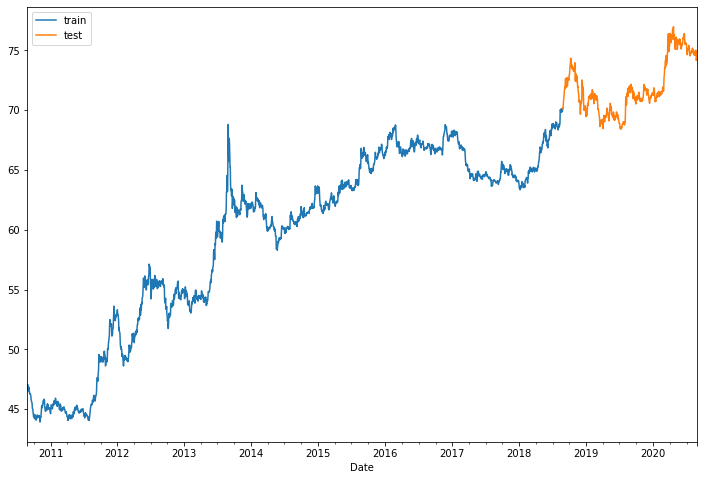

In [265]:
split_date = pd.Timestamp('26-08-2018')

train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(kind='line',figsize=(12,8))
test.plot(ax=ax,kind='line',figsize=(12,8))
plt.legend(['train', 'test'])

## Data Normalization

In [266]:
from sklearn.preprocessing import StandardScaler

In [267]:
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [268]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [269]:
print(y_test)

[[1.41778016]
 [1.47530834]
 [1.50308056]
 [1.53746522]
 [1.56523744]
 [1.61416945]
 [1.63665173]
 [1.66244022]
 [1.64128043]
 [1.7292258 ]
 [1.75369181]
 [1.69021244]
 [1.67394585]
 [1.65318281]
 [1.74046694]
 [1.76294921]
 [1.71666218]
 [1.67103638]
 [1.70079234]
 [1.75765927]
 [1.759643  ]
 [1.74840186]
 [1.7444344 ]
 [1.73649948]
 [1.79138268]
 [1.79138268]
 [1.84692713]
 [1.884618  ]
 [1.90313281]
 [1.94214617]
 [1.97851456]
 [1.96661218]
 [1.94016244]
 [1.88197303]
 [1.90313281]
 [1.86279697]
 [1.88065054]
 [1.87139313]
 [1.85089459]
 [1.87536059]
 [1.8740381 ]
 [1.83171853]
 [1.83171853]
 [1.86213572]
 [1.8542008 ]
 [1.89123043]
 [1.92826006]
 [1.86147448]
 [1.72724207]
 [1.81188123]
 [1.79535014]
 [1.72856456]
 [1.71930715]
 [1.73253202]
 [1.78278652]
 [1.75038559]
 [1.71004974]
 [1.65781152]
 [1.66640768]
 [1.61747567]
 [1.59367091]
 [1.57713982]
 [1.49580688]
 [1.49117818]
 [1.51299921]
 [1.50837051]
 [1.48919445]
 [1.37546059]
 [1.35826826]
 [1.46274471]
 [1.4746471 ]
 [1.47

## Models

### Linear Regression  Model

In [302]:
df=ind_exchange_data
y=df.Price[:-1]
x=df.Price[1:]
x=list(x)
y=list(y)
tr_x=x[0:2000]
tr_y=y[0:2000]
dataset=[]
for i in range(len(tr_x)):
  a=[tr_x[i],tr_y[i]]
  dataset.append(a)

In [303]:
from math import sqrt
def rmse_metric(actual, predicted):
	sum_error = 0.0
	for i in range(len(actual)):
		prediction_error = predicted[i] - actual[i]
		sum_error += (prediction_error ** 2)
	mean_error = sum_error / float(len(actual))
	return sqrt(mean_error)

In [304]:
def evaluate_algorithm(dataset, algorithm):
	test_set = list()
	for row in dataset:
		row_copy = list(row)
		row_copy[-1] = None
		test_set.append(row_copy)
	predicted,b0,b1 = algorithm(dataset, test_set)
	print(predicted)
	actual = [row[-1] for row in dataset]
	rmse = rmse_metric(actual, predicted)
	return rmse,predicted,actual,b0,b1

In [305]:
def mean(values):
	return sum(values) / float(len(values)) 


def covariance(x, mean_x, y, mean_y):
	covar = 0.0
	for i in range(len(x)):
		covar += (x[i] - mean_x) * (y[i] - mean_y)
	return covar

  
def variance(values, mean):
	return sum([(x-mean)**2 for x in values]) 

In [306]:
def coefficients(dataset):
	x = [row[0] for row in dataset]
	y = [row[1] for row in dataset]
	x_mean, y_mean = mean(x), mean(y)
	b1 = covariance(x, x_mean, y, y_mean) / variance(x, x_mean)
	b0 = y_mean - b1 * x_mean
	return [b0, b1] 

In [307]:
def simple_linear_regression(train, test):
	predictions = list()
	b0, b1 = coefficients(train)
	for row in test:
		yhat = b0 + b1 * row[0]
		predictions.append(yhat)
	return predictions,b0,b1  

In [308]:
def mean_error(actual,predicted):
  e=0
  for i in range(len(actual)):
    e+=abs(actual[i]-predicted[i])
  return e/len(actual)  


In [309]:
print(test)

             Price
Date              
2018-08-27  70.165
2018-08-28  70.100
2018-08-29  70.535
2018-08-30  70.745
2018-08-31  71.005
...            ...
2020-08-20  75.012
2020-08-21  74.920
2020-08-23  74.922
2020-08-24  74.168
2020-08-25  74.327

[523 rows x 1 columns]


In [310]:
print("predictions")
rmse,predicted,actual,b0,b1 = evaluate_algorithm(dataset, simple_linear_regression)
print()
print("For training set")
print('RMSE: %.3f' % (rmse))
print("MAE-score: %.3f" %(mean_error(actual,predicted)))
test=x[2000:]

predictions
[74.16067210515594, 74.91314357597142, 74.91114763042549, 75.00296112553825, 74.8372976452261, 74.5618571598878, 74.7345064496107, 74.8652408828691, 74.80236859817232, 74.78141116994007, 74.6017760708064, 74.86124899177725, 75.0159347715868, 74.8911881749662, 74.78939495212379, 75.0528597641865, 75.17561041526118, 74.90915168487956, 74.868234801188, 74.93909086806852, 74.90016992992287, 74.7913908976697, 74.75147198675111, 74.80636048926418, 74.6017760708064, 74.53191797669885, 74.74149225902147, 74.8881942566473, 75.17062055139635, 75.11573204888327, 75.39716037085937, 75.20255568013123, 75.18559014299082, 75.14567123207223, 74.9360969497496, 74.80137062539936, 74.62672539013052, 74.62772336290348, 74.74149225902147, 75.47999211101545, 75.53488061352851, 75.49995156647475, 75.60972857150088, 75.57679546999304, 75.6546373462843, 75.49296575706398, 75.7793839429049, 76.24843114619839, 76.38814733441346, 76.27837032938733, 76.23845141846873, 75.96800079699526, 76.038856863875

In [311]:
def get_pred(test,b0,b1):
	predictions = list()
	for i in range(len(test)):
		yhat = b0 + (b1 * test[i])
		predictions.append(yhat)
	return predictions

In [312]:
predictions=get_pred(test,b0,b1) 

In [313]:
import math
actual=y[2000:]
def rmse_error(actual,predicted):
  e=0
  for i in range(len(actual)):
    e+=abs(actual[i]-predicted[i])
  return math.sqrt(e/len(actual))
print("For test set")
print('RMSE: %.3f' % (rmse_error(actual,predictions)))
print("r2-score: %.3f" %(r2_score(actual,predictions)))
print("MAE-score: %.3f" %(mean_error(actual,predictions)))

For test set
RMSE: 0.449
r2-score: 0.996
MAE-score: 0.202


### Neural Network  Model

In [314]:
inputs = np.array(x)
inputs = inputs.reshape((2609, 1))
targets = np.array(y)
targets = targets.reshape((2609, 1))
print(inputs)
print()
print(targets)

[[74.168]
 [74.922]
 [74.92 ]
 ...
 [46.915]
 [46.81 ]
 [46.845]]

[[74.327]
 [74.168]
 [74.922]
 ...
 [47.065]
 [46.915]
 [46.81 ]]


In [315]:
def forward_prop(input, weights):
  activations = []
  w1 = weights[0]
  w2 = weights[1]
  z1 = np.dot(w1, input)
  a1 = z1
  activations.append(a1)
  z2 = np.dot(w2, a1)
  a2 = z2
  activations.append(a2)
  output = activations[1]
  return activations, output

In [316]:
def backward_prop(input_vec, weights, activations, output, target, eta):
  w1 = weights[0]
  w2 = weights[1]
  error_at_op = (output - target) 
  error_at_hidden = error_at_op * np.transpose(w2)
  #update w2
  w2 -= eta * error_at_op * np.transpose(activations[0])
  #update w1
  w1 -= eta * error_at_hidden * input_vec
  weights[0] = w1
  weights[1] = w2
  return weights

In [317]:
def train(inputs, targets, weights, iterations):
  eta = 0.25
  for iter_no in range(iterations):
    outputs = []
    for i in range(len(inputs)):
      input_vec = inputs[i].reshape((1, 1))
      target = targets[i]
      activations, output = forward_prop(input_vec, weights)
      outputs.append(output)
      weights = backward_prop(input_vec, weights, activations, output, target, eta)
    print("Iteration no: " + str(iter_no + 1) + "-Outputs : " + str([outputs[i][0][0] for i in range(len(outputs))]))
  output_vals_final = np.array([outputs[i][0][0] for i in range(len(outputs))])
  output_vals_final = output_vals_final.reshape((len(inputs), 1))
  return weights, output_vals_final 

In [318]:
if __name__=='__main__':
  eta = 0.25
  hidden_units = 4
  weights = []
  w1 = np.random.rand(hidden_units, 1) 
  w2 = np.random.rand(1, hidden_units) 
  weights.append(w1)
  weights.append(w2)
  print("Training the model")
  new_weights, output_vals = train(X_train, y_train, weights, 10)
  print("\nTesting the model")
  _, test_output_vals = train(X_test, y_test, new_weights, 1)

Training the model
Iteration no: 1-Outputs : [-1.5501948514115187, -1.7751289199925118, -1.5053432678619352, -1.7206851065788438, -1.6933219432228157, -1.6464294207091261, -1.7990320207228383, -1.5777896708357932, -1.7028654474578468, -1.752485248688002, -1.704937256427449, -1.7722888351168995, -1.6738116466187245, -1.8074575298679525, -1.6752137605407444, -1.8457652867697425, -1.7551233050293882, -1.898535994570719, -1.7018930937936743, -1.9996538270637634, -1.6208240522861006, -2.3125515347638, -1.2437092145477942, -2.7630156067127007, -0.6714179005593834, -2.9411325660170737, -0.717893838624218, -2.1923099334865466, -1.7504401294557257, -2.264601672335192, -1.7111357143584403, -2.1845635142524644, -1.7589526090628707, -2.131293220689821, -1.8503210224612938, -2.2201686146595794, -1.798380463694797, -2.1634827736868365, -1.7817760597860577, -2.212957789797593, -1.73914212328917, -2.1338453156688892, -1.852078392372797, -2.079228387629224, -1.864917985094091, -2.0998580837554446, -1.8

In [319]:
print("Metrics for ANN")
print("\nFor test set")
print('RMSE: %.3f' % (rmse_metric(y_test_new, test_output_vals_new)))
print("r2-score: %.3f" %(r2_score(y_test_new, test_output_vals_new)))
print("MAE-score: %.3f" %(mean_error(y_test_new, test_output_vals_new)))

Metrics for ANN

For test set
RMSE: 0.100
r2-score: 0.884
MAE-score: 0.018


### LSTM

In [270]:
#pre process
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [271]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [272]:
model_lstm.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
2086/2086 [==============================] - 4s 1ms/step - loss: 0.3250 - rmse: 0.4956
Epoch 2/100
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0070 - rmse: 0.0736
Epoch 3/100
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0036 - rmse: 0.0549
Epoch 4/100
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0036 - rmse: 0.0548
Epoch 5/100
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0032 - rmse: 0.0528
Epoch 6/100
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0030 - rmse: 0.0513
Epoch 7/100
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0029 - rmse: 0.0508
Epoch 8/100
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0029 - rmse: 0.0505
Epoch 9/100
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0029 - rmse: 0.0503
Epoch 10/100
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0028 - rmse: 0.0502
Epoch 11/

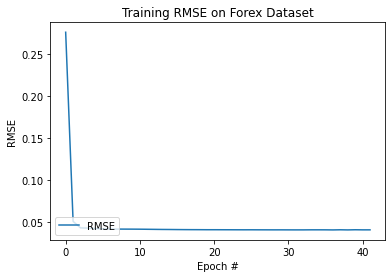

In [274]:
N = 42
plt.figure()
plt.plot(np.arange(0, N), history_model_lstm.history["rmse"], label="RMSE")
plt.title("Training RMSE on Forex Dataset")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend(loc="lower left")

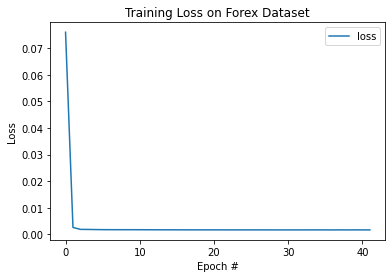

In [275]:
N = 42
plt.figure()
plt.plot(np.arange(0, N), history_model_lstm.history["loss"], label="loss")
plt.title("Training Loss on Forex Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

In [276]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)

train_mse = metrics.mean_squared_error(y_train, y_train_pred_lstm)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test_lstm)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is: {:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The  MAE on the Train set is: {:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred_lstm)))

print("The  RMSE on the Train set is: {:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is: {:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is: {:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is: {:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is: {:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test_lstm)))
print("The  RMSE on the Test set is: {:0.3f}".format(rmse_test))

The R2 score on the Train set is: 0.977
The  MAE on the Train set is: 0.131
The  RMSE on the Train set is: 0.152
The Adjusted R2 score on the Train set is: 0.977

The R2 score on the Test set is: 0.974
The Adjusted R2 score on the Test set is: 0.974
The  MAE on the Test set is: 0.037
The  RMSE on the Test set is: 0.047


### GRU

In [277]:
from keras.layers import GRU
K.clear_session()
model_gru = Sequential()
model_gru.add(GRU(7, input_shape=(1, X_train.shape[1]), activation='linear', kernel_initializer='lecun_uniform', return_sequences=False))
model_gru.add(Dense(1))
model_gru.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 7)                 210       
_________________________________________________________________
dense (Dense)                (None, 1)                 8         
Total params: 218
Trainable params: 218
Non-trainable params: 0
_________________________________________________________________


In [278]:
model_gru.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
history_model_gru = model_gru.fit(X_tr_t, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
2086/2086 [==============================] - 4s 1ms/step - loss: 0.2405 - rmse: 0.4261
Epoch 2/100
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0024 - rmse: 0.0480
Epoch 3/100
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0032 - rmse: 0.0526
Epoch 4/100
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0015 - rmse: 0.0389
Epoch 5/100
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0017 - rmse: 0.0404
Epoch 6/100
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0017 - rmse: 0.0409
Epoch 7/100
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0017 - rmse: 0.0411
Epoch 8/100
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0017 - rmse: 0.0414
Epoch 9/100
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0018 - rmse: 0.0416
Epoch 10/100
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0018 - rmse: 0.0417
Epoch 11/

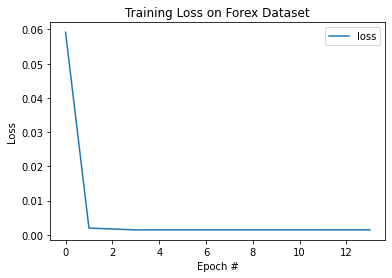

In [279]:
N = 14
plt.figure()
plt.plot(np.arange(0, N), history_model_gru.history["loss"], label="loss")
plt.title("Training Loss on Forex Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

In [280]:
y_pred_test_gru = model_gru.predict(X_tst_t)
y_train_pred_gru = model_gru.predict(X_tr_t)

train_mse = metrics.mean_squared_error(y_train, y_train_pred_gru)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test_gru)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:{:0.3f}".format(r2_score(y_train, y_train_pred_gru)))
print("The  MAE on the Train set is:{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred_gru)))

print("The  RMSE on the Train set is:{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred_gru)
print("The Adjusted R2 score on the Train set is:{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:{:0.3f}".format(r2_score(y_test, y_pred_test_gru)))
r2_test = r2_score(y_test, y_pred_test_gru)
print("The Adjusted R2 score on the Test set is:{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test_gru)))
print("The  RMSE on the Test set is:{:0.3f}".format(rmse_test))

The R2 score on the Train set is:0.983
The  MAE on the Train set is:0.120
The  RMSE on the Train set is:0.131
The Adjusted R2 score on the Train set is:0.983

The R2 score on the Test set is:0.787
The Adjusted R2 score on the Test set is:0.786
The  MAE on the Test set is:0.097
The  RMSE on the Test set is:0.136


### Ensemble Model

In [242]:
from keras.layers import GRU

In [289]:
def define_lstm_model_bagging():
  K.clear_session()
  model_lstm = Sequential()
  model_lstm.add(LSTM(50, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
  model_lstm.add(Dense(1))
  model_lstm.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
  return model_lstm

In [290]:
model_summary = define_lstm_model_bagging()
model_summary.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [293]:
def train_lstm_model_bagging(model_name):
  model_lstm = define_gru_model_bagging()
  early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
  history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=40, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])
  new_path = "/content/drive/MyDrive/ML_Forex_Saved_Stuff/lstm bagging/" + str(model_name) + ".h5"
  model_lstm.save(new_path)
  return model_lstm

In [295]:
def bagging_lstm_models(k_val, X_tr_t, y_train):
  model_preds = []
  for iter_no in range(k_val):
    #sampling dataset 
    di_size = len(X_train) // k_val
    if di_size <= 1:
      print("Your k value is too small")
      break
    limit_val = len(X_tr_t) - di_size
    X_i = []
    y_i = []
    for i in range(0, k_val):
      rand_val_gen = randint(0, limit_val)
      X_i = X_tr_t[rand_val_gen:rand_val_gen + di_size] 
      y_i = y_train[rand_val_gen:rand_val_gen + di_size]

    # training the lstm
    X_i = np.array(X_i)
    y_i = np.array(y_i)
    print("Training model " + str(iter_no+1))
    model_name = "lstm_model_bagging_" + str(iter_no + 1)
    model_lstm = train_lstm_model_bagging(model_name)

    #using the gru to store predictions
    preds_train = model_lstm.predict(X_i)
    preds_test = model_lstm.predict(X_tst_t)

    pred_vals = [preds_train, preds_test]
    model_preds.append(pred_vals)

  return model_preds

In [296]:
def preprocess_final_predictions(final_preds):
  train_example_preds = []
  test_example_preds = []
  for test_example_no in range(len(final_preds[0][1])):
    pred_vals = []
    for model_no in range(len(final_preds)):
      train_and_test_preds = final_preds[model_no]
      test_preds = train_and_test_preds[1]
      pred_vals.append(test_preds[test_example_no])
    test_example_preds.append(pred_vals)

  for train_example_no in range(len(final_preds[0][0])):
    pred_vals = []
    for model_no in range(len(final_preds)):
      train_and_test_preds = final_preds[model_no]
      train_preds = train_and_test_preds[0]
      pred_vals.append(train_preds[train_example_no])
    train_example_preds.append(pred_vals)

  return train_example_preds, test_example_preds

In [300]:
import statistics
def get_final_predictions_overall(preds):
  final_preds_overall = []
  for i in range(len(preds)):
    pred_values = preds[i]
    pred_values.sort()
    median_val = statistics.median(pred_values)
    final_preds_overall.append(median_val)
  return final_preds_overall

In [298]:
final_preds = bagging_gru_models(5, X_tr_t,y_train)

Training model 1
Epoch 1/40
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0648 - rmse: 0.2256
Epoch 2/40
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0074 - rmse: 0.0820
Epoch 3/40
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0210 - rmse: 0.1176
Epoch 4/40
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0053 - rmse: 0.0649
Epoch 5/40
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0024 - rmse: 0.0474
Epoch 6/40
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0016 - rmse: 0.0400
Epoch 7/40
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0016 - rmse: 0.0390
Epoch 8/40
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0016 - rmse: 0.0394
Epoch 9/40
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0016 - rmse: 0.0396
Epoch 10/40
2086/2086 [==============================] - 3s 1ms/step - loss: 0.0016 - rmse: 0.0398
Ep

In [301]:
train_example_preds, test_example_preds = preprocess_final_predictions(final_preds)
final_train_preds = get_final_predictions_overall(train_example_preds)
final_test_preds = get_final_predictions_overall(test_example_preds)
print("Test r2 score")
print(r2_score(y_test, final_test_preds))

Test r2 score
0.8835409019798763
